In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
path='/Volumes/Reiterlab_3/mcc_timecourse/Ad9/'
results_file = '/Volumes/Reiterlab_3/mcc_timecourse/Ad9/Ad9_scanpy_v2.h5ad'  # the file that will store the analysis results

sc.settings.set_figure_params(dpi=80)

adata = sc.read_10x_mtx(path + 'outs/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

adata

AnnData object with n_obs × n_vars = 17734 × 31053 
    var: 'gene_ids', 'feature_types'

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


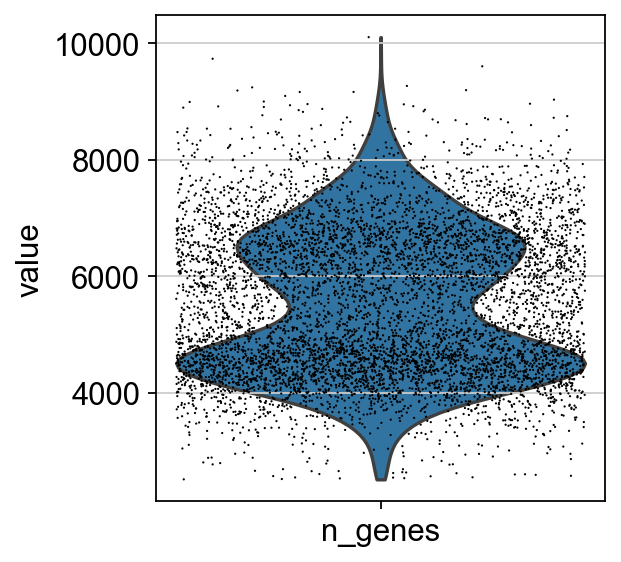

/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


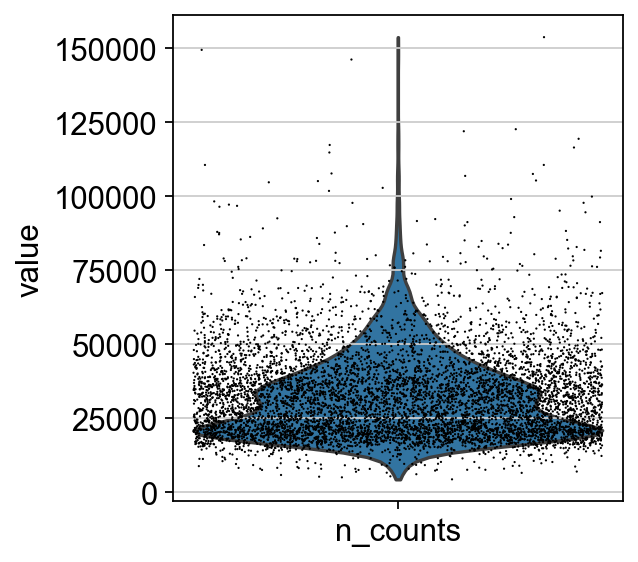

/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


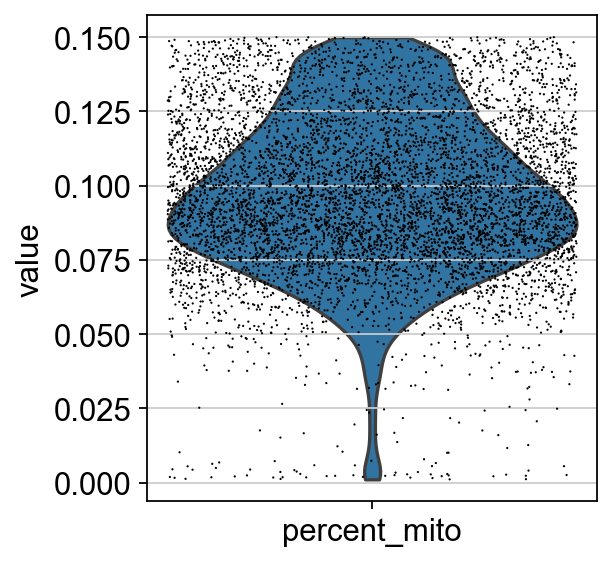

In [4]:
## filter based on Ad9_v2_parameters.csv
adata = adata[adata.obs['n_genes'] > 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]
sc.pl.violin(adata, ['n_genes'],jitter=0.4)
sc.pl.violin(adata, ['n_counts'],jitter=0.4)
sc.pl.violin(adata, ['percent_mito'],jitter=0.4)

In [5]:
####### doublets ##########

import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os

In [7]:
counts_matrix = adata.X
print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))

Counts matrix shape: 6989 rows, 20430 columns


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 4.6%
Estimated detectable doublet fraction = 55.3%
Overall doublet rate:
	Expected   = 12.0%
	Estimated  = 8.2%
Elapsed time: 22.7 seconds
Detected doublet rate = 6.3%
Estimated detectable doublet fraction = 64.3%
Overall doublet rate:
	Expected   = 12.0%
	Estimated  = 9.9%


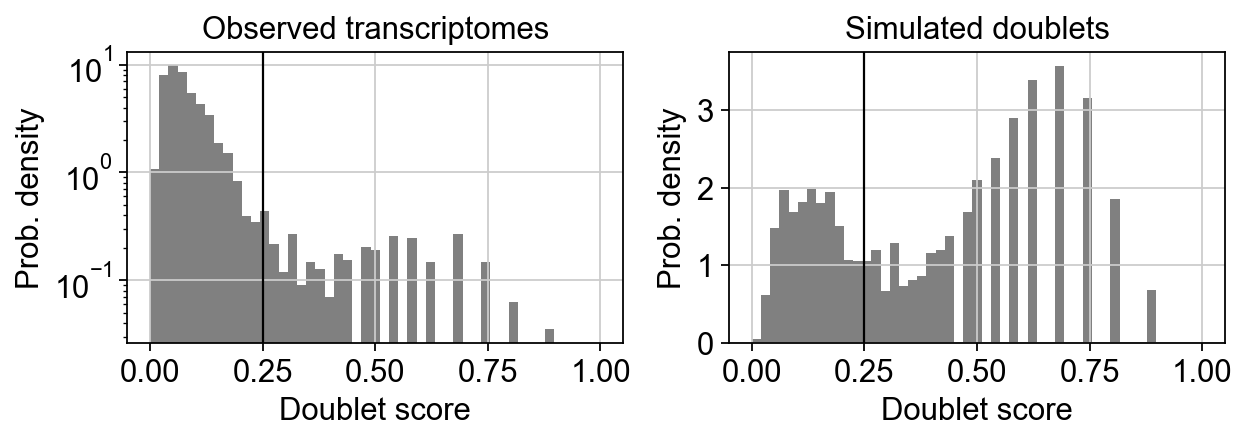

In [8]:
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=.12)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

predicted_doublets = scrub.call_doublets(threshold=0.25)

scrub.plot_histogram();

Running UMAP...


/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/lb/anaconda3/envs/scanpy/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../Users/lb

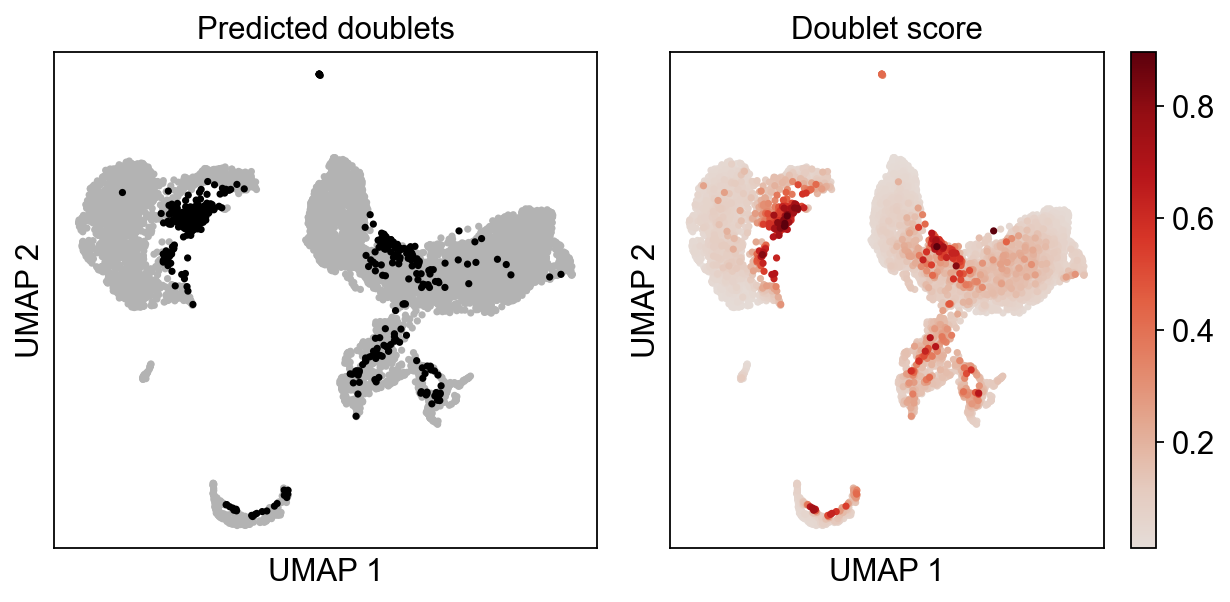

In [9]:
print('Running UMAP...')
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True);

In [10]:
cellbarc = adata.obs.index

df=pd.DataFrame({
        'cell_barcodes':cellbarc,
        'doublet_score':scrub.doublet_scores_obs_,
        'predicted_doublet':scrub.predicted_doublets_
        })
df.to_csv(path+'v2/Ad9_v2_scrublet_12perc_thresh0.25_output_table.csv',index=False)